In [5]:
!pip install haystack-ai --upgrade python-pptx python-docx boto3 pypdf opensearch-py retrying

In [4]:
import os
import time
import boto3
import logging
import pprint
import json

s3_client = boto3.client('s3')
sts_client = boto3.client('sts')
session = boto3.session.Session()
region =  session.region_name

In [1]:
pipe_yaml = '''
components:
  file_classifier:
    type: haystack.components.routers.file_type_router.FileTypeRouter
    init_parameters:
      mime_types:
      - text/plain
      - application/pdf
      - application/vnd.openxmlformats-officedocument.wordprocessingml.document
      - application/vnd.openxmlformats-officedocument.presentationml.presentation
  txt_converter:
    init_parameters:
      encoding: utf-8
    type: haystack.components.converters.txt.TextFileToDocument
  pdf_converter:
    init_parameters:
      converter:
        init_parameters: {}
        type: haystack.components.converters.pypdf.DefaultConverter
    type: haystack.components.converters.pypdf.PyPDFToDocument
  pptx_converter:
    init_parameters: {}
    type: haystack.components.converters.pptx.PPTXToDocument
  docx_converter:
    init_parameters: {}
    type: haystack.components.converters.docx.DOCXToDocument
  joiner:
    type: haystack.components.joiners.document_joiner.DocumentJoiner
    init_parameters:
      join_mode: concatenate
      sort_by_score: false
  cleaner:
    init_parameters:
      remove_empty_lines: true
      remove_extra_whitespaces: false
      remove_regex: null
      remove_repeated_substrings: true
      remove_substrings: null
    type: haystack.components.preprocessors.document_cleaner.DocumentCleaner
  splitter:
    init_parameters:
      split_by: word
      split_length: 350
      split_overlap: 20
    type: haystack.components.preprocessors.document_splitter.DocumentSplitter
connections:
  - receiver: txt_converter.sources
    sender: file_classifier.text/plain
  - receiver: pdf_converter.sources
    sender: file_classifier.application/pdf
  - receiver: docx_converter.sources
    sender: file_classifier.application/vnd.openxmlformats-officedocument.wordprocessingml.document
  - receiver: pptx_converter.sources
    sender: file_classifier.application/vnd.openxmlformats-officedocument.presentationml.presentation
  - receiver: joiner.documents
    sender: txt_converter.documents
  - receiver: joiner.documents
    sender: pdf_converter.documents
  - receiver: joiner.documents
    sender: docx_converter.documents
  - receiver: joiner.documents
    sender: pptx_converter.documents
  - receiver: cleaner.documents
    sender: joiner.documents
  - receiver: splitter.documents
    sender: cleaner.documents
max_loops_allowed: 100
metadata: {}
'''

In [2]:
from haystack import Pipeline
pipe = Pipeline.loads(pipe_yaml)

c:\Users\joshl\anaconda3\lib\site-packages\haystack\core\errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(


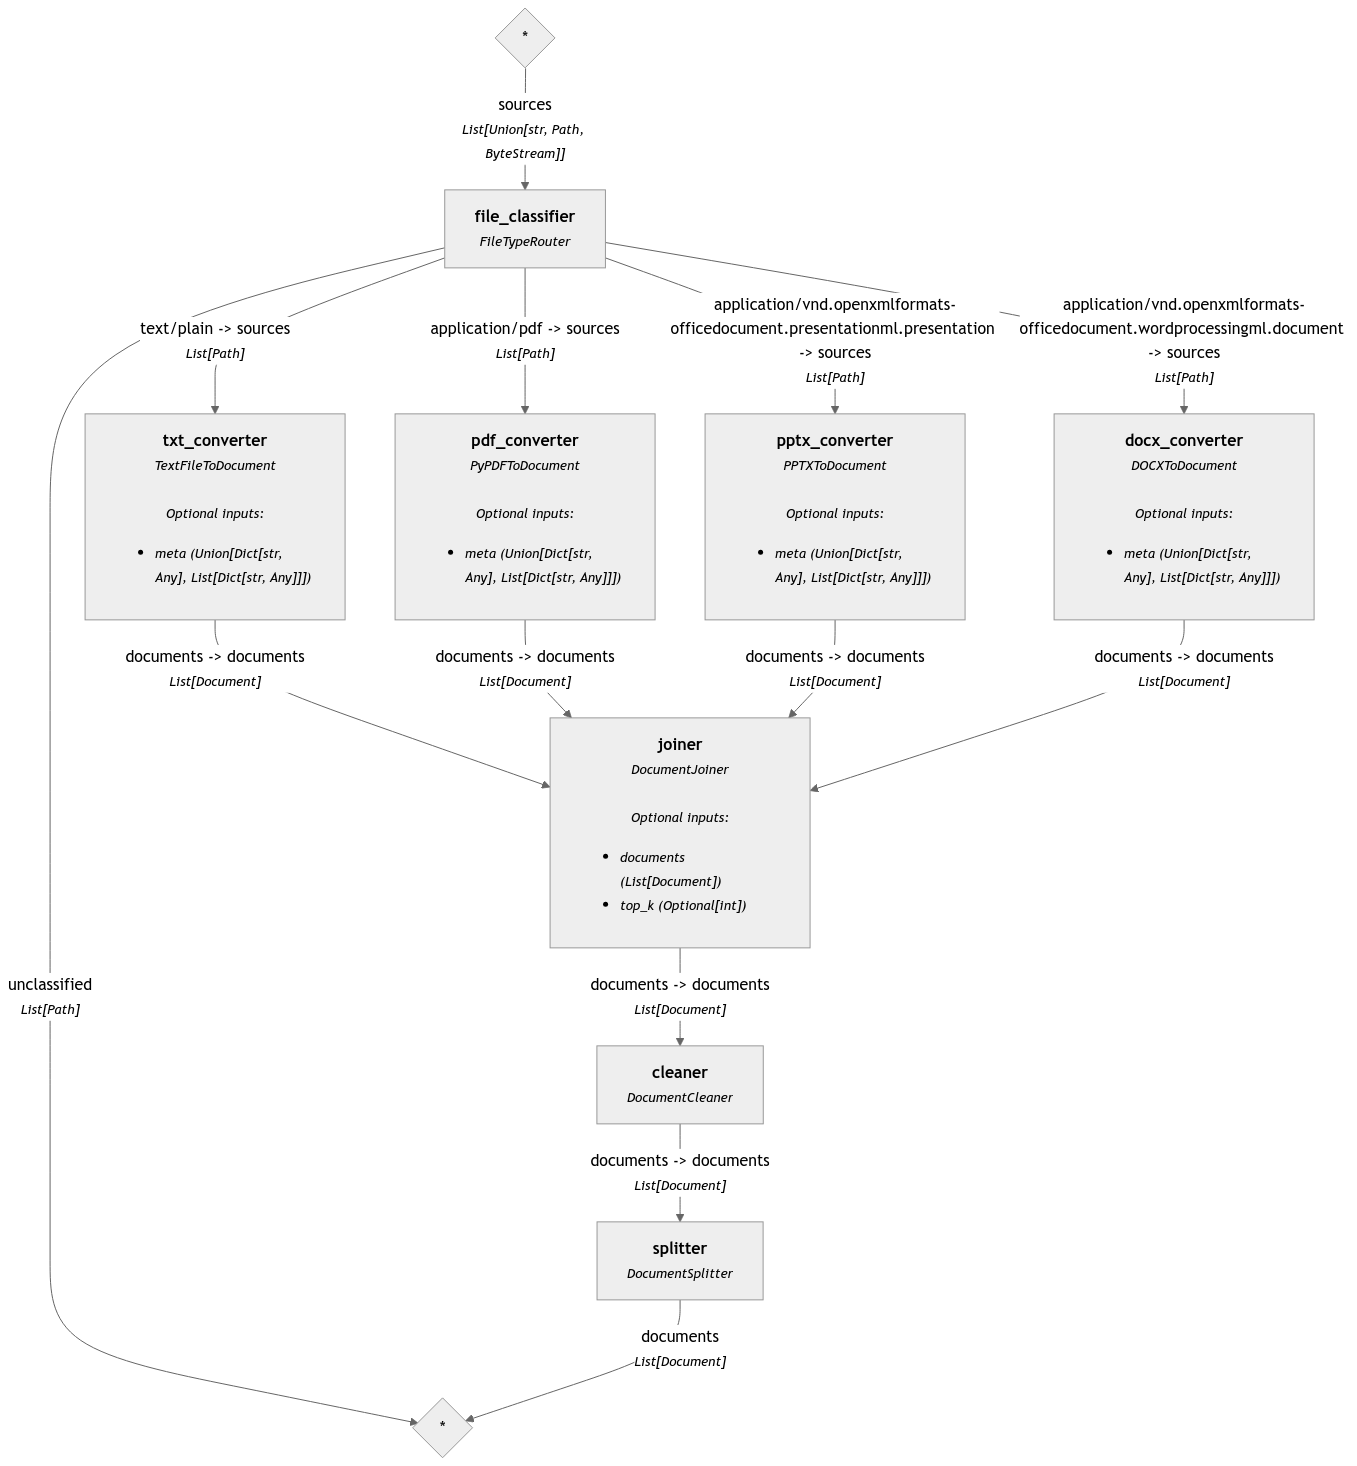

In [3]:
pipe.show()

In [ ]:
import json
import os
import tempfile
import boto3
import logging
from haystack import Pipeline


logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

def load_pipe():
    pipe = Pipeline.load_from_yaml(pipe_yaml)
    return pipe

def lambda_handler(event, context):
    logger.debug('input={}'.format(json.dumps(event)))
    s3 = boto3.client('s3')

    # Extract relevant information from the input event
    input_files = event.get('inputFiles')
    input_bucket = event.get('bucketName')

    if not all([input_files, input_bucket]):
        raise ValueError("Missing required input parameters")

    output_files = []
    pipe = load_pipe()

    with tempfile.TemporaryDirectory() as temp_dir:
        for input_file in input_files:
            content_batches = input_file.get('contentBatches', [])
            file_metadata = input_file.get('fileMetadata', {})
            original_file_location = input_file.get('originalFileLocation', {})

            processed_batches = []

            for batch in content_batches:
                input_key = batch.get('key')

                if not input_key:
                    raise ValueError("Missing key in content batch")

                # Download file from S3 to temp directory
                local_file_path = os.path.join(temp_dir, os.path.basename(input_key))
                s3.download_file(input_bucket, input_key, local_file_path)

                # Process content using Haystack pipeline
                processed_content = process_content(local_file_path, pipe)

                output_key = f"Output/{input_key}"

                # Write processed content back to S3
                write_to_s3(s3, input_bucket, output_key, processed_content)

                # Add processed batch information
                processed_batches.append({
                    'key': output_key
                })

            # Prepare output file information
            output_file = {
                'originalFileLocation': original_file_location,
                'fileMetadata': file_metadata,
                'contentBatches': processed_batches
            }
            output_files.append(output_file)

    result = {'outputFiles': output_files}

    return result

def write_to_s3(s3_client, bucket, key, content):
    s3_client.put_object(Bucket=bucket, Key=key, Body=json.dumps(content))

def process_content(file_path: str, pipe: Pipeline) -> dict:
    # Run the pipeline on the file
    result = pipe.run(file_paths=[file_path])

    # Process the result into the expected output format
    processed_content = {
        'fileContents': []
    }

    
    for doc in result['splitter']['documents']:
        processed_content['fileContents'].append({
            'contentType': 'text',  # Adjust as needed
            'contentMetadata': {},  # Add metadata if available
            'contentBody': doc.content
        })

    return processed_content

In [1]:
from bedrock_kb import BedrockKnowledgeBase

In [ ]:
knowledge_base_custom = BedrockKnowledgeBase(
    kb_name=f'{knowledge_base_name_custom}-{suffix}',
    kb_description=knowledge_base_description,
    data_bucket_name=bucket_name,
    lambda_function_name=lambda_function_name,
    intermediate_bucket_name=intermediate_bucket_name, 
    chunking_strategy = "CUSTOM", 
    suffix = f'{suffix}-c'
)

In [ ]:
# ensure that the kb is available
time.sleep(30)
# sync knowledge base
knowledge_base_custom.start_ingestion_job()

In [ ]:
kb_id_custom = knowledge_base_custom.get_knowledge_base_id()

In [ ]:
response_custom_ret = bedrock_agent_runtime_client.retrieve(
    knowledgeBaseId=kb_id_custom, 
    nextToken='string',
    retrievalConfiguration={
        "vectorSearchConfiguration": {
            "numberOfResults":5,
        } 
    },
    retrievalQuery={
        'text': query
    }
)
print("# of citations or chunks used to generate the response: ", len(response_custom_ret['retrievalResults']))
response_print(response_custom_ret)